<p align="center">
<FONT FACE="times new roman" SIZE=5>
<br>
<img src="https://www.usergioarboleda.edu.co/wp-content/uploads/ultimatum/imagens/logo-mobile-UniversidadSergioArboleda.png"
width="750" height="250">
</img>
<br>
<i><b>Docente:</b> Juan Pablo Ospina.</i>
<br>
<i><b>Asignatura:</b> Vida artificial</i>
<br>
<i><b>Estudiantes:</b> Chiara Valenzuela, Andrea Terraza y Miguel Thomas</i>
<br>
<i><b>Tema:</b> Parcial 1</i>
<br>
<i><b>Grupo:</b> Dracarys (A)</i>
<br>
<img src='https://i.pinimg.com/originals/ba/78/85/ba788588817b74ef4713383ceac3e0ef.gif'>
<br>
<i>16/09/24</i>
</FONT>
</p>

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Lectura

In [2]:
file_urls = [
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Carvajal_2023%5B8%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Ciudad%20Bolivar_2023%5B42%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Colina_2023%5B74%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Fontibon_2023%5B52%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Las%20Ferias_2023%5B92%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/MinAmbiente_2023%5B20%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Puente%20Aranda_2023%5B55%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/San%20Cristobal_2023%5B23%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Suba_2023%5B37%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Tunal_2023%5B50%5D.xlsx',
    'https://raw.githubusercontent.com/ChiaraVL/VidaArtificial/main/Parcial1/Usaquen_2023%5B18%5D.xlsx'
]

In [3]:
dfs = []

for file_url in file_urls:

    d = pd.read_excel(file_url, header=3, skiprows=[4])

    file_name = file_url.split('/')[-1]
    ubicacion = file_name.split('_')[0]
    d['Ubicacion'] = ubicacion

    if 'Summary:' in d.iloc[:, 0].values:
        summary_index = d[d.iloc[:, 0] == 'Summary:'].index[0]
        df_clean = d.iloc[:summary_index]
    else:

        df_clean = d

    dfs.append(df_clean)

df = pd.concat(dfs, ignore_index=True)

In [4]:
df.head()

Unnamed: 0 PM10 Vel Viento 10M Dir Viento 10M Temperatura  \
0  01-01-2023 01:00   42            0.3            283        12.2   
1  01-01-2023 02:00   55            0.5            294          12   
2  01-01-2023 03:00   50            0.4            321        11.3   
3  01-01-2023 04:00   48            0.3            303        11.3   
4  01-01-2023 05:00   48            0.3            345        10.9   

  Temperatura 8M Temperatura 20M     HR Presion Baro Rad Solar  ... PM2.5  \
0           11.7            ----  86.94          564         0  ...    36   
1           11.5            ----  86.97          564         0  ...    38   
2           10.8            ----  86.58          563         0  ...    32   
3           10.8            ----  86.76          563         0  ...    40   
4           10.5            ----  86.68          563         0  ...    39   

    CO   SO2 Ubicacion Vel Viento Dir Viento  BBP BC ug/m3 PM10 Flow Temp_4m  
0  0.7  ----  Carvajal        NaN        NaN  NaN      NaN       NaN     NaN  
1  0.5  ----  Carvajal        NaN        NaN  NaN      NaN       NaN     NaN  
2  0.5  ----  Carvajal        NaN        NaN  NaN      NaN       NaN     NaN  
3  0.4  ----  Carvajal        NaN        NaN  NaN      NaN       NaN     NaN  
4  0.5  ----  Carvajal        NaN        NaN  NaN      NaN       NaN     NaN  

[5 rows x 25 columns]

# Preprocesamiento

In [5]:
df = df.rename(columns={'Unnamed: 0': 'Fecha'})
df['Fecha'] = df['Fecha'].str.replace('24:00', '23:59')
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d-%m-%Y %H:%M')
df.set_index('Fecha', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96360 entries, 2023-01-01 01:00:00 to 2023-12-31 23:59:00
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PM10             96360 non-null  object
 1   Vel Viento 10M   8760 non-null   object
 2   Dir Viento 10M   8760 non-null   object
 3   Temperatura      87600 non-null  object
 4   Temperatura 8M   8760 non-null   object
 5   Temperatura 20M  8760 non-null   object
 6   HR               52560 non-null  object
 7   Presion Baro     61320 non-null  object
 8   Rad Solar        52560 non-null  object
 9   Precipitacion    96360 non-null  object
 10  OZONO            96360 non-null  object
 11  NO               96360 non-null  object
 12  NO2              96360 non-null  object
 13  NOX              96360 non-null  object
 14  PM2.5            96360 non-null  object
 15  CO               96360 non-null  object
 16  SO2              70080 non-null  object
 

In [7]:
numeric_columns = [
    'PM10', 'Vel Viento 10M', 'Dir Viento 10M', 'Temperatura', 'Temperatura 8M',
    'Temperatura 20M', 'HR', 'Presion Baro', 'Rad Solar', 'Precipitacion', 'OZONO',
    'NO', 'NO2', 'NOX', 'PM2.5', 'CO', 'SO2', 'Vel Viento', 'Dir Viento',
    'BBP', 'BC ug/m3', 'PM10 Flow', 'Temp_4m'
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Reemplazo de valores faltantes

In [8]:
df['PM2.5'].isnull().sum()

1962

In [9]:
df['pm2-5_MA'] = df['PM2.5'].rolling(window=24, min_periods=1).mean()
df['PM2.5'].fillna(df['pm2-5_MA'], inplace=True)
df.drop(columns=['pm2-5_MA'], inplace=True)
print(f"Hay {df['PM2.5'].isnull().sum()} valores nulos en la columna 'PM2.5'")

Hay 632 valores nulos en la columna 'PM2.5'


In [10]:
df['PM2.5'] = df['PM2.5'].interpolate(method='linear')
print(f"Hay {df['PM2.5'].isnull().sum()} valores nulos en la columna 'PM2.5'")

Hay 0 valores nulos en la columna 'PM2.5'


Incluso luego de reemplazar los valores faltantes con la media móvil, existían algunos que seguían como valores nulos, por lo que se decidió usar el método de interpolación lineal para llenar los valores faltantes. Esto calcula los valores intermedios basándose en los datos circundantes.

## Columnas a conservar

In [11]:
columns_to_keep = [
    'PM2.5', 'Dir Viento 10M', 'Temperatura 20M','Ubicacion'
]

df_filtered = df[columns_to_keep]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96360 entries, 2023-01-01 01:00:00 to 2023-12-31 23:59:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PM2.5            96360 non-null  float64
 1   Dir Viento 10M   8533 non-null   float64
 2   Temperatura 20M  7733 non-null   float64
 3   Ubicacion        96360 non-null  object 
dtypes: float64(3), object(1)
memory usage: 3.7+ MB


In [12]:
for col in ['Dir Viento 10M', 'Temperatura 20M']:
    df_filtered[col] = df[col].interpolate(method='linear', limit_direction='both')

In [13]:
df_filtered.isnull().sum()

PM2.5              0
Dir Viento 10M     0
Temperatura 20M    0
Ubicacion          0
dtype: int64

# Análisis

## Análisis estadístico

In [14]:
df_filtered.groupby('Ubicacion')['PM2.5'].describe()

count       mean        std  min  25%   50%   75%    max
Ubicacion                                                                  
Carvajal          8760.0  13.393082   8.986639  0.0  7.0  11.0  18.0   63.0
Ciudad%20Bolivar  8760.0  17.489042  12.128646  0.5  7.7  14.8  24.2  126.0
Colina            8760.0  10.381480   7.623614  0.0  4.6   7.6  14.0   54.9
Fontibon          8760.0  17.956113  10.962991  0.0  9.8  15.9  24.0   95.8
Las%20Ferias      8760.0  13.956146   9.316006  0.0  7.0  12.0  19.0   84.0
MinAmbiente       8760.0  13.001571  10.131320  0.0  6.0  10.0  18.0  110.0
Puente%20Aranda   8760.0  13.108413  10.431743  0.0  4.6  10.4  19.1   66.3
San%20Cristobal   8760.0  11.165424  10.451870  0.0  4.0   8.0  16.0  137.0
Suba              8760.0  14.563700   9.912934  0.0  7.0  12.0  20.0   91.0
Tunal             8760.0  18.159229  12.090990  0.0  9.0  15.0  25.0  141.0
Usaquen           8760.0   9.770386   8.504935  0.0  4.0   7.0  13.0   58.0

In [15]:
df_filtered.describe()

PM2.5  Dir Viento 10M  Temperatura 20M
count  96360.000000    96360.000000     96360.000000
mean      13.904053      276.206471        14.213957
std       10.517780       35.527381         1.028417
min        0.000000        0.000000         5.700000
25%        6.000000      282.000000        14.100000
50%       11.000000      282.000000        14.100000
75%       19.000000      282.000000        14.100000
max      141.000000      360.000000        22.800000

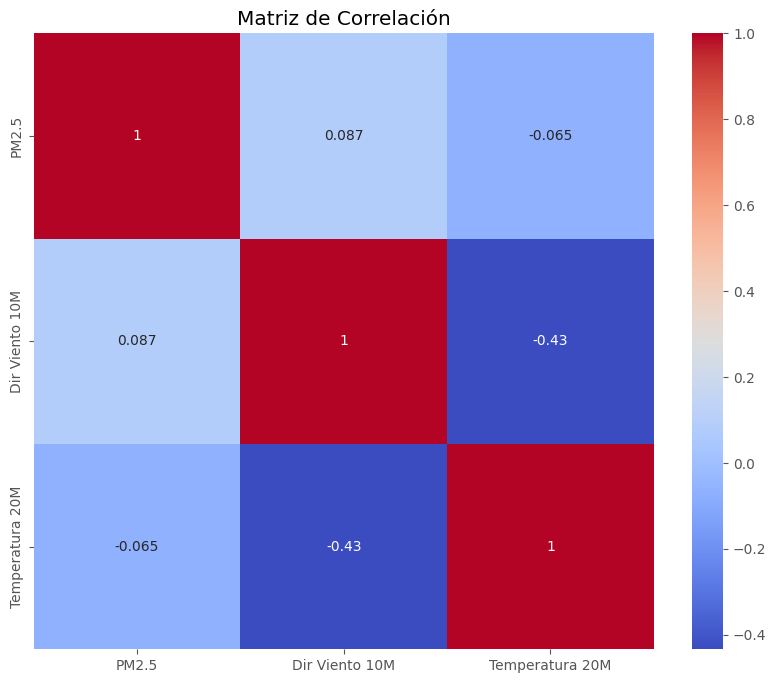

In [16]:
correlation_matrix = df_filtered.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## Análisis como serie de tiempo

In [17]:
fig = px.line(df_filtered['PM2.5'], color=df_filtered['Ubicacion'],title='Serie de Tiempo - Concentración del PM2.5 por Estación de Monitoreo')
fig.update_layout(xaxis_title='Fecha', yaxis_title='Concentración del PM2.5 en μg/m^3')
fig.show()

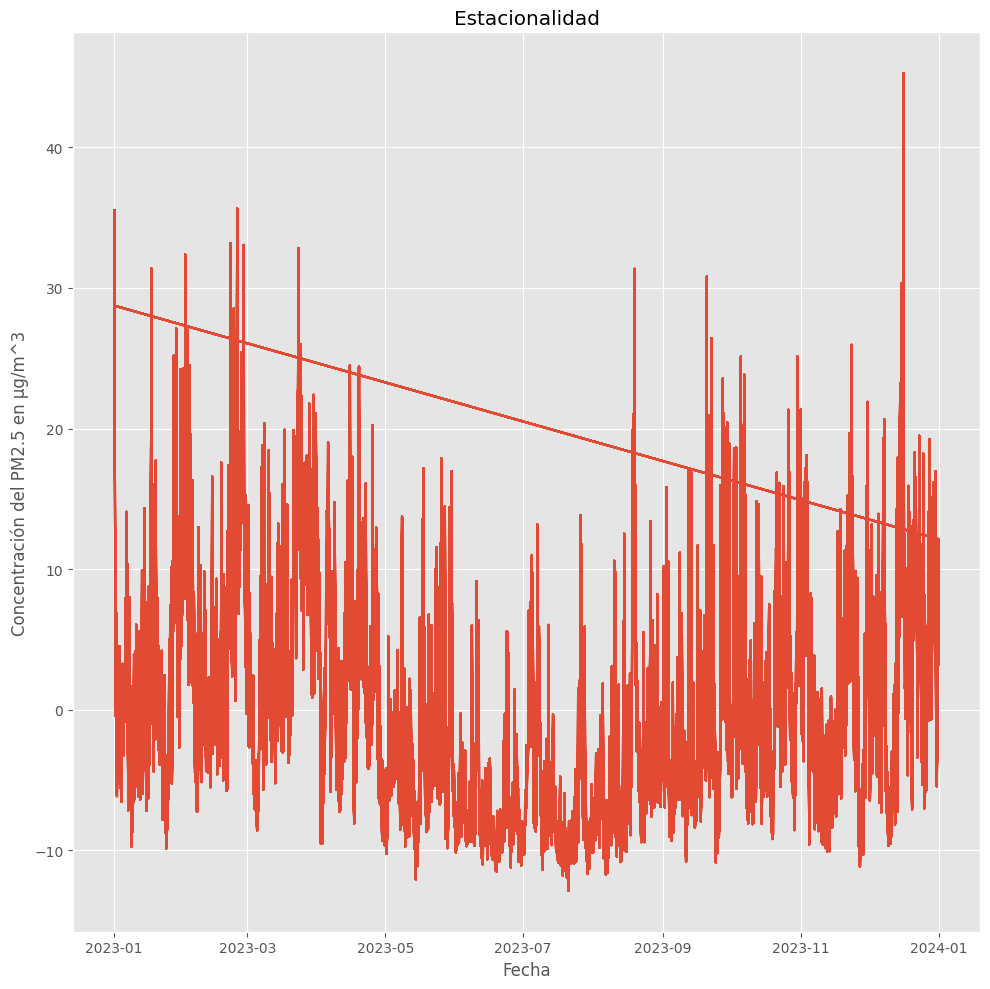

In [18]:
decomposition = seasonal_decompose(df_filtered['PM2.5'], model='additive', period=8760)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

#axes[0].plot(df_filtered['PM2.5'])
#axes[0].set_title('Original')

#axes.plot(trend)
#axes.set_title('Trend')

axes.plot(seasonal)
axes.set_title('Estacionalidad')
axes.set_xlabel('Fecha')
axes.set_ylabel('Concentración del PM2.5 en μg/m^3')

#axes[3].scatter(df_filtered.index , residual)
#axes[3].set_title('Residual')

fig.tight_layout()

In [19]:
df_filtered['rolling_mean'] = df_filtered['PM2.5'].rolling(window=8760).mean()

fig = px.line(df_filtered['rolling_mean'], color= df_filtered['Ubicacion'],title='Tendencia anual de concentración de PM2.5 por Estación de Monitoreo a través de la media móvil')
fig.update_layout(xaxis_title='Fecha', yaxis_title='Concentración del PM2.5 en μg/m^3')
fig.show()

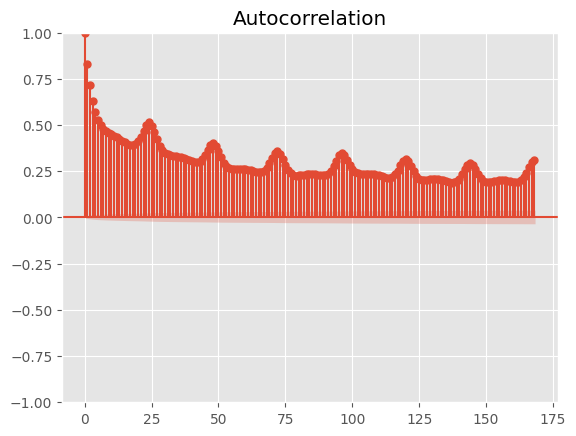

In [20]:
fig = tsaplots.plot_acf(df_filtered['PM2.5'], lags = 168)
plt.show ()

In [25]:
fig = px.line(
    df_filtered.assign(
        year=df_filtered.index.year,
        month=df_filtered.index.month,
        month_name=df_filtered.index.strftime("%b"),
    )
    .groupby(["year", "month", "month_name", "Ubicacion"], as_index=False)
    .agg(value=("PM2.5", "mean")),
    x="month_name",
    y="value",
    color="year",
    facet_col="Ubicacion",
    facet_col_wrap=2,
    title='Serie de Tiempo - PM2.5 por localidad',
)

fig.update_layout(
    xaxis_title='Mes',
    yaxis_title='Concentración de PM2.5 en µg/m³',)

fig.for_each_yaxis(lambda axis: axis.update(title_text='Concentración' if axis.domain[0] == 0 else '', title_standoff=20))

fig.show()

In [22]:
fig = px.line( df_filtered.assign(
        year=df_filtered.index.year,
        month=df_filtered.index.month,
        month_name=df_filtered.index.strftime("%b"),
        day_of_week = df_filtered.index.day_name()
    ).groupby(["day_of_week", "month","month_name"], as_index=False)
            .agg(value=("PM2.5", "mean")),
    x="month_name",
    y="value",
    color="day_of_week",
    title='Serie de Tiempo - PM2.5 por días de la semana',
)
fig.update_layout(
    xaxis_title='Mes',
    yaxis_title='Concentración del PM2.5 en μg/m^3'
)

fig.show()

In [26]:
fig = px.line( df_filtered.assign(
        year=df_filtered.index.year,
        month=df_filtered.index.month,
        hour=df_filtered.index.hour,
        month_name=df_filtered.index.strftime("%b"),
        day_of_week = df_filtered.index.day_name()
    ).groupby(["day_of_week", "hour"], as_index=False)
            .agg(value=("PM2.5", "mean")),
    x="hour",
    y="value",
    color="day_of_week",
    title='Serie de Tiempo - PM2.5 por hora del día',
)
fig.update_layout(
    xaxis_title='Día',
    yaxis_title='Concentración del PM2.5 en μg/m^3'
)

fig.show()